In [1]:
bfs_file = "/Users/sakshmenon/Desktop/PLM/Workflow Gen/Similarity Search/s_cerevisiae2s_pombe.bfs.k30.txt"

#### Obtaining Values

In [2]:
import re

def extract_query_and_matches(text):
    # Pattern to extract the query value
    # query_pattern = r"Query:\s+>([\w.]+)"
    
    # # Pattern to extract Top matches and their IDs
    # top_match_pattern = r"Top\d+:\s+([\d.]+)\s+>([\w.]+)"
    
    # # Extract the query value
    # query_match = re.search(query_pattern, text)
    # query_value = query_match.group(1) if query_match else None
    
    # # Extract all top matches and corresponding protein IDs
    # top_matches = re.findall(top_match_pattern, text)

    text = text.split('\n')[:-1]
    query = text[0].split('\t')[1:]
    top_matches = text[1:]

    
    return {
        "Query": query,
        "Matches": [{"Score": match.split('\t')[1], "Protein ID": match.split('\t')[2][1:]} for match in top_matches]
    }

match_list = []
with open(bfs_file) as file_obj:
    content = file_obj.read()
    queries = content.split('\n\n')
    for query in queries[1:-1]:
        result = extract_query_and_matches(query)
        match_list.append(result)


## Score Gap Analysis

In [515]:
def compute_score_differences(query_list, num_matches):
    result = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches']

        scores = [float(match['Score']) for match in matches[:num_matches+1]]
        
        # Extract the top match score
        top_score = float(matches[0]['Score'])/max(scores)
        p_id = matches[0]['Protein ID']

        # Compute the difference for the given number of matches
        placeholder = {query_id[0] : {
            "Top Protein ID": p_id,
            "Top Score": scores[0],
            "Normalized Top Score": round(float(top_score),6)}
        }
        for i in range(1, min(num_matches + 1, len(matches))):
            match_score = float(matches[i]['Score'])/max(scores)
            placeholder[query_id[0]][f"Match{i+1} Score"] = round(top_score - match_score,6)
            placeholder[query_id[0]][f"Match{i+1} Protein ID"] = matches[i]['Protein ID']
        
        result.append(placeholder)
    
    return result

# Compute differences for the top 3 matches
num_matches_to_compare = 3
result = compute_score_differences(match_list, num_matches_to_compare)


In [577]:
def compute_score_differences(query_list, num_matches):
    result = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches']

        scores = [float(match['Score']) for match in matches[:num_matches+1]]
        
        # Extract the top match score
        top_score = float(matches[0]['Score'])/max(scores)
        p_id = matches[0]['Protein ID']

        # Compute the difference for the given number of matches
        placeholder = {query_id[0] : {
            "Top Protein ID": p_id,
            "Top Score": scores[0],
            "Normalized Top Score": round(float(top_score),6)}
        }

        match_score = float(matches[1]['Score'])/max(scores)
        placeholder[query_id[0]]["Match 2 Score"] = scores[1]
        placeholder[query_id[0]]["Match 2 Normalized Score"] = round(top_score - match_score,6)
        placeholder[query_id[0]]["Match 2 Protein ID"] = matches[1]['Protein ID']
        placeholder[query_id[0]]["Confidence Score (%)"] = round((1 - (top_score/match_score))*100, 6)
        
        result.append(placeholder)

    ranks = [[[*result[res].values()][0]['Confidence Score (%)'], res] for res in range(0, len(result))]
    sorted_values = []
    ranks.sort()
    ranks.reverse()
    for rank in ranks:
        sorted_values.append(result[rank[1]])

    return sorted_values, ranks

# Compute differences for the top 3 matches
num_matches_to_compare = 1
result = compute_score_differences(match_list, num_matches_to_compare)


## Z-Score Normalization

In [14]:
import numpy as np
from scipy.stats import norm

def compute_z_scores(query_list):
    result = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches']

        scores = [float(item['Score']) for item in matches]

        # Calculate mean and standard deviation of the scores
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        # Calculate the z-scores for each score
        z_scores = [(score - mean_score) / std_score for score in scores]

        confidence_scores = [100 - norm.cdf(z) * 100 for z in z_scores]  # Confidence as a percentile (0-100%)

        # The confidence level is the percentage of the data that falls within a given range of the normal distribution.
        # This is done by calculating 2 * (cumulative probability) - 1, assuming you are dealing with a two-tailed test (symmetrical distribution).

        # Create a list of dictionaries containing the score, protein ID, Z-score, and confidence score
        output = [{'Score': item['Score'], 
                'Protein ID': item['Protein ID'], 
                'Z-Score': round(z_score, 6), 
                'Confidence Score (%)': round(confidence_score, 7)} 
                for item, z_score, confidence_score in zip(matches[:], z_scores[:], confidence_scores[:])]


        # Sort the list by Z-score in ascending order
        output_sorted = sorted(output, key=lambda x: x['Z-Score'])

        result.append({query_id[0] : output_sorted})

    ranks = [[[*result[res].values()][0][0]['Confidence Score (%)'], res] for res in range(0, len(result))]
    sorted_values = []
    ranks.sort()
    ranks.reverse()
    for rank in ranks:
        sorted_values.append(result[rank[1]])

    return sorted_values, ranks

# Compute mean, standard deviation, and z-scores for the top match
result, ranks = compute_z_scores(match_list)

## Local Neighborhood Density: 

In [481]:
import numpy as np

def analyze_density(query_list, num_top_hits=5, neighborhood_size=0.01):
    results = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches'][:5]
        
        # Extract all the scores as floats and sort them in ascending order
        scores = sorted([float(match['Score']) for match in matches])
        
        # Calculate differences between consecutive scores
        score_diffs = np.diff(scores)
        
        # Calculate the mean distance for the top hits (num_top_hits defines how many top hits we analyze)
        top_hit_scores = scores[:num_top_hits]
        top_hit_diffs = np.diff(top_hit_scores)  # Differences between consecutive top hits
        mean_top_hit_diff = np.mean(top_hit_diffs)
        
        # Calculate the mean distance for the entire score list (global density measure)
        mean_global_diff = np.mean(score_diffs)
        
        # Check if the top hits are clustered closely together (lower differences compared to global mean)
        is_top_clustered = mean_top_hit_diff < mean_global_diff
        
        # Count how many scores fall within the defined "neighborhood size" of the top score
        top_score = top_hit_scores[0]
        neighborhood_density = sum(1 for score in scores if abs(score - top_score) <= neighborhood_size)
        
        # Store results
        results.append({
            'Query': query_id,
            'Top Hit Scores': top_hit_scores,
            'Mean Distance Between Top Hits': mean_top_hit_diff,
            'Mean Global Distance': mean_global_diff,
            'Neighborhood Density': neighborhood_density
        })
    
    return results

# Analyze the density of top hits for each query
result = analyze_density(match_list)
print(result)

#     Local Neighborhood Density: 
        # Analyze the density of reference vectors in the neighborhood of the input vector. If the top hits are close in similarity, 
        # while other vectors are far, it indicates that these top hits are more distinct and thus significant.


[{'Query': ['>NP_013207.1 AAA family ATPase midasin [Saccharomyces cerevisiae S288C]'], 'Top Hit Scores': [0.439, 1.125, 1.144, 1.15, 1.155], 'Mean Distance Between Top Hits': 0.179, 'Mean Global Distance': 0.179, 'Neighborhood Density': 1}, {'Query': ['>NP_012980.1 dynein heavy chain [Saccharomyces cerevisiae S288C]'], 'Top Hit Scores': [0.844, 1.177, 1.208, 1.25, 1.252], 'Mean Distance Between Top Hits': 0.10200000000000001, 'Mean Global Distance': 0.10200000000000001, 'Neighborhood Density': 1}, {'Query': ['>NP_011967.1 histone acetyltransferase TRA1 [Saccharomyces cerevisiae S288C]'], 'Top Hit Scores': [0.323, 0.391, 0.867, 0.933, 0.964], 'Mean Distance Between Top Hits': 0.16025, 'Mean Global Distance': 0.16025, 'Neighborhood Density': 1}, {'Query': ['>NP_010745.3 E3 ubiquitin-protein ligase TOM1 [Saccharomyces cerevisiae S288C]'], 'Top Hit Scores': [0.461, 1.062, 1.08, 1.088, 1.153], 'Mean Distance Between Top Hits': 0.173, 'Mean Global Distance': 0.173, 'Neighborhood Density': 1

## Cluster Analysis

In [566]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

def cluster_top_hits(query_list, n_clusters, num_top_hits=30, clustering_method='kmeans', eps=0.1, min_samples=2):
    results = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches']

        max_val = max([[float(match['Score'])] for match in matches])
        
        # Extract all the scores as floats
        scores = np.array([[float(match['Score'])/max_val[0]] for match in matches])
        
        # Apply clustering based on the selected method
        if clustering_method == 'kmeans':
            # Using 2 clusters (one for top hits and one for the rest)
            kmeans = KMeans(n_clusters)
            labels = kmeans.fit_predict(scores)
        elif clustering_method == 'dbscan':
            # Using DBSCAN with user-defined eps (neighborhood size) and min_samples
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(scores)
        
        # Get the labels for the top hits
        top_hit_scores = scores[:num_top_hits]
        top_hit_labels = labels[:num_top_hits]
        
        # Check if all top hits belong to the same cluster
        all_same_cluster = len(set(top_hit_labels)) == 1
        
        # Store results
        placeholder = kmeans.cluster_centers_
        top_hit_labels = top_hit_labels.tolist(),
        cluster_dist = np.mean(placeholder - kmeans.cluster_centers_[top_hit_labels[0][0]])*3/2

        output = {'Top 1 Match Protein ID' : matches[0]['Protein ID'],
                  'Top 1 Match Score' : matches[0]['Score'],
                  'Top 2 Match Protein ID' : matches[1]['Protein ID'],
                  'Top 2 Match Score' :  matches[1]['Score'],
                  'Top Match Cluster Distance' : cluster_dist,
                  "Confidence Score (%)" : norm.cdf(cluster_dist) * 100
                  }

        results.append({query_id[0] : output})
        
    ranks = [[[*results[res].values()][0]['Confidence Score (%)'], res] for res in range(0, len(results))]
    sorted_values = []
    ranks.sort()
    ranks.reverse()
    for rank in ranks:
        sorted_values.append(results[rank[1]])

    return sorted_values, ranks
    # return results



# Cluster the top hits for each query using k-means and dbscan
result_kmeans = cluster_top_hits(match_list, 3, clustering_method='kmeans')
# result_dbscan = cluster_top_hits(match_list, clustering_method='dbscan', eps=0.1, min_samples=2)

## Score Gap Method 1 File Output

In [538]:
import json

# all queries

json_object = json.dumps(result, indent=4)

with open("score_gap_1_all.json", "w") as outfile:
	outfile.write(json_object)

# 30 sampled queries

sampled_results = result[:10] + result[int(len(result)/2) : int(len(result)/2) + 10]+ result[-10:]

json_object = json.dumps(sampled_results, indent=4)

with open("score_gap_1_sampled.json", "w") as outfile:
	outfile.write(json_object)

## Score Gap Method 2 File Output

In [578]:
    # Score Gap Analysis: 
    #     Measure the gap between the top similarity score and the next few scores. 
    #     A large gap between the highest similarity score and the others suggests that the top hit is likely more significant.

import json

# all queries

json_object = json.dumps(result, indent=4)

with open("score_gap_2_all.json", "w") as outfile:
	outfile.write(json_object)

# 30 sampled queries

sampled_results = result[:10] + result[int(len(result)/2) : int(len(result)/2) + 10]+ result[-10:]

json_object = json.dumps(sampled_results, indent=4)

with open("score_gap_2_sampled.json", "w") as outfile:
	outfile.write(json_object)

## Z Score File Output

In [9]:
    # Compute Z-Scores: 
    #     Calculate the mean and standard deviation of all cosine similarity scores for the given input vector. 
    #     Convert the top similarity scores into z-scores to see how many standard deviations away from the mean they are. 
    #     Higher z-scores indicate higher significance.

import json

# all queries

json_object = json.dumps(result, indent=4)

with open("z_score_all.json", "w") as outfile:
	outfile.write(json_object)

# 30 sampled queries

sampled_results = result[:10] + result[int(len(result)/2) : int(len(result)/2) + 10]+ result[-10:]

json_object = json.dumps(sampled_results, indent=4)

with open("z_score_sampled.json", "w") as outfile:
	outfile.write(json_object)

## Cluster Analysis File Output

In [570]:
# Cluster Analysis: 
    #     Use clustering techniques (e.g., k-means or DBSCAN) to determine whether the top hits belong to the same cluster. 
    #     If the top hits are tightly clustered, it suggests higher reliability.


import json

result = cluster_top_hits(match_list, 3, clustering_method='kmeans')

# all queries

json_object = json.dumps(result, indent=4)

with open("cluster_all.json", "w") as outfile:
	outfile.write(json_object)

# 30 sampled queries

sampled_results = result[:10] + result[int(len(result)/2) : int(len(result)/2) + 10]+ result[-10:]

json_object = json.dumps(sampled_results, indent=4)

with open("cluster_sampled.json", "w") as outfile:
	outfile.write(json_object)

## Distribution Plots

/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_11662/2276607468.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, color='purple', ax=axes[0])


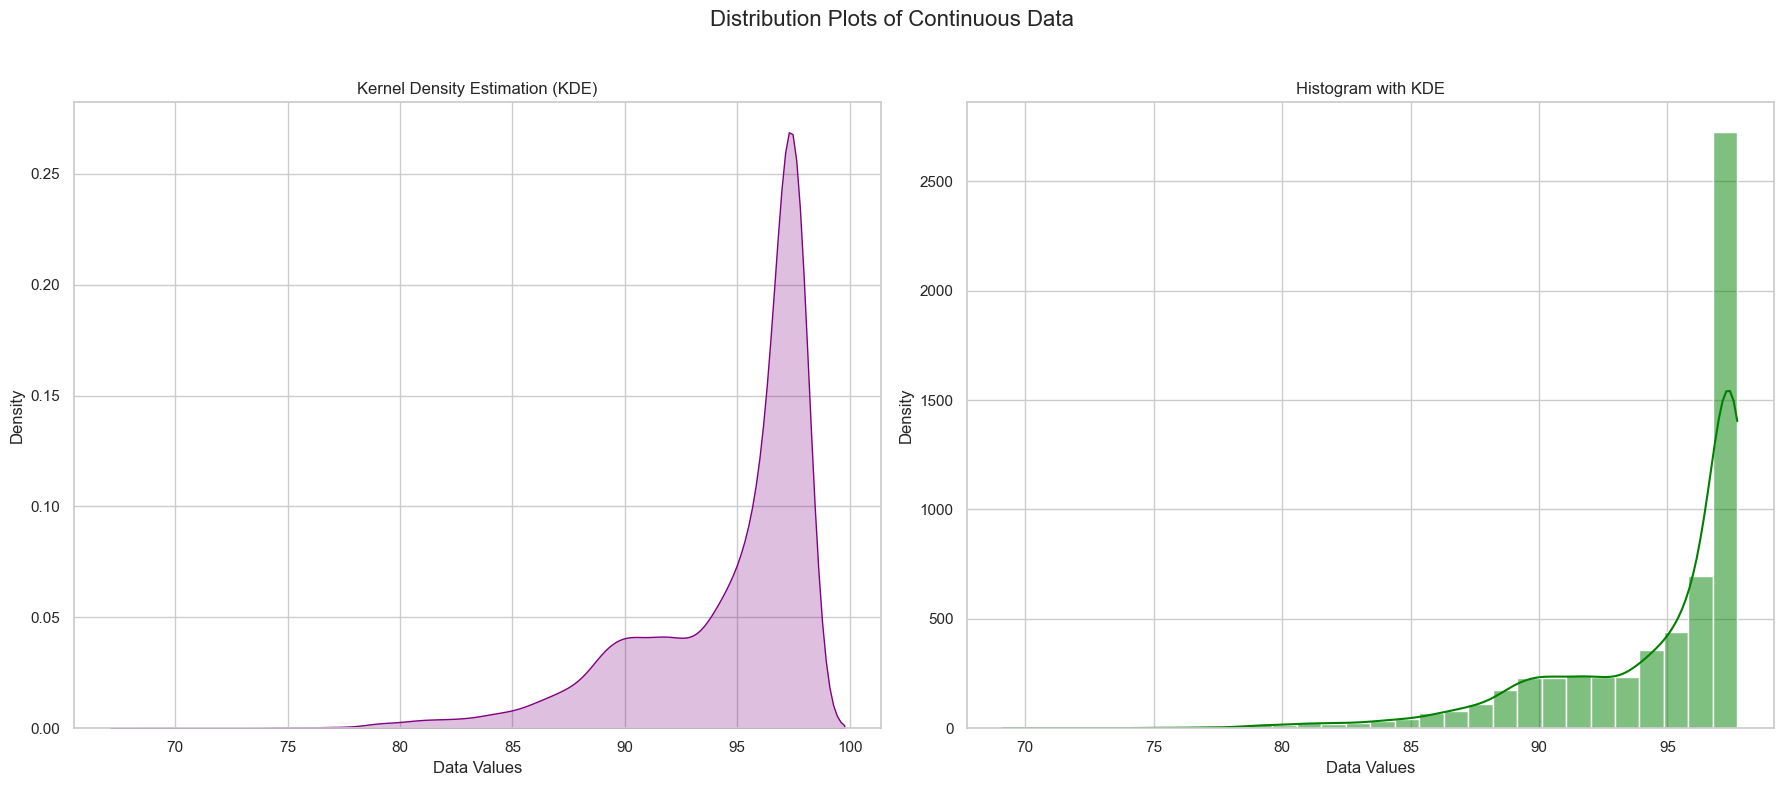

In [571]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate some sample continuous data
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=500)  # Normally distributed data

def plot_distribution(data):
    # Set the style for better aesthetics
    sns.set(style="whitegrid")

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # KDE Plot
    sns.kdeplot(data, shade=True, color='purple', ax=axes[0])
    axes[0].set_title('Kernel Density Estimation (KDE)')
    axes[0].set_xlabel('Data Values')
    axes[0].set_ylabel('Density')

    # Histogram with KDE overlay
    sns.histplot(data, bins=30, kde=True, color='green', ax=axes[1])
    axes[1].set_title('Histogram with KDE')
    axes[1].set_xlabel('Data Values')
    axes[1].set_ylabel('Density')

    # Display the plots
    plt.suptitle('Distribution Plots of Continuous Data', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Call the function to create and display the plots
data = [i[0] for i in ranks]
plot_distribution(data)


Entropy

In [1]:
import numpy as np
from scipy.stats import entropy

def compute_entropy(query_list, num_top_hits=5):
    results = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches']
        
        # Extract the top-N scores as floats
        top_scores = np.array([float(match['Score']) for match in matches[:num_top_hits]])
        
        # Normalize the scores to get probabilities
        normalized_scores = top_scores / top_scores.sum()
        
        # Compute the entropy of the top-N scores
        score_entropy = entropy(normalized_scores)
        
        # Store the result
        results.append({
            'Query': query_id,
            'Top Scores': top_scores.tolist(),
            'Entropy': score_entropy
        })
        
    return results

# Example data
query_list = [
    {
        'Query': 'NP_013207.1',
        'Matches': [
            {'Score': '0.439', 'Protein ID': 'NP_588370.1'},
            {'Score': '1.125', 'Protein ID': 'NP_596080.2'},
            {'Score': '1.144', 'Protein ID': 'NP_594482.1'},
            {'Score': '1.150', 'Protein ID': 'NP_596604.1'},
            {'Score': '1.155', 'Protein ID': 'NP_596560.1'}
        ]
    },
    {
        'Query': 'NP_012980.1',
        'Matches': [
            {'Score': '0.844', 'Protein ID': 'NP_001342921.1'},
            {'Score': '1.177', 'Protein ID': 'NP_596233.1'},
            {'Score': '1.208', 'Protein ID': 'NP_594043.2'},
            {'Score': '1.250', 'Protein ID': 'NP_588379.1'},
            {'Score': '1.252', 'Protein ID': 'NP_588492.1'}
        ]
    }
]

# Compute entropy for the top 5 hits
entropy_results = compute_entropy(query_list, num_top_hits=5)

# Output the results
for result in entropy_results:
    print(f"Query: {result['Query']}")
    print(f"Top Scores: {result['Top Scores']}")
    print(f"Entropy: {result['Entropy']:.4f}")
    print()


Query: NP_013207.1
Top Scores: [0.439, 1.125, 1.144, 1.15, 1.155]
Entropy: 1.5617

Query: NP_012980.1
Top Scores: [0.844, 1.177, 1.208, 1.25, 1.252]
Entropy: 1.5998



gausian distribution

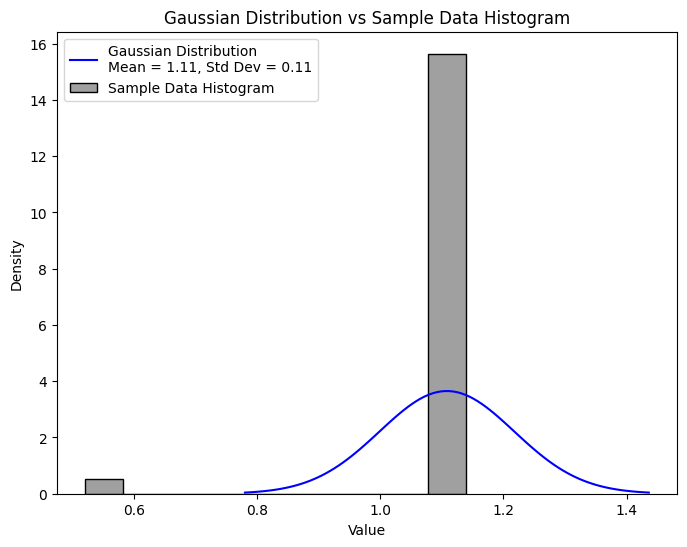

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given sample data
# data = np.array([56, 45, 67, 44, 59, 50, 52, 62, 58, 64])
data = [float(i['Score']) for i in [*result[0].values()][0]]


# Step 1: Calculate the mean and standard deviation of the sample data
mean = np.mean(data)
std_dev = np.std(data)

# Step 2: Generate a Gaussian distribution using the sample's mean and standard deviation
# Create a range of values (x-axis) around the mean
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Calculate the probability density function (PDF) for the Gaussian distribution
gaussian_pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev)**2)

# Step 3: Plot the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.plot(x_values, gaussian_pdf, label=f'Gaussian Distribution\nMean = {mean:.2f}, Std Dev = {std_dev:.2f}', color='blue')

# Step 4: Plot the histogram of the original sample data for comparison
sns.histplot(data, kde=False, stat='density', bins=10, color='gray', label='Sample Data Histogram')

# Add labels and legend
plt.title('Gaussian Distribution vs Sample Data Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()
